# 🔬 Recursive Deep Research Agent

**Inference-Time Compute Engine for Open-Ended Research**

This notebook implements a recursive research agent that:
- Decomposes complex queries into a DAG of sub-questions
- Executes searches in parallel where possible
- Uses a self-correction (Critic) loop to verify information sufficiency
- Compares against a Naive RAG baseline

---

## Architecture
- **Planner**: Claude Sonnet (DAG generation)
- **Worker**: GPT-4o-mini (search summarization)
- **Critic**: Claude Sonnet (answer evaluation)
- **Judge**: GPT-4o (A/B evaluation)
- **Search**: Tavily API

---
## 1. Setup & Configuration

In [1]:
#@title 1.1 Mount Google Drive & Setup Paths
#@markdown Mount Google Drive to save checkpoints and logs persistently.

from google.colab import drive
import os
import shutil

# Mount Google Drive
drive.mount('/content/drive')

# Project configuration
PROJECT_NAME = "Recursive-Deep-Research"
DRIVE_BASE_PATH = "/content/drive/MyDrive/Colab Notebooks"
DRIVE_PROJECT_PATH = os.path.join(DRIVE_BASE_PATH, PROJECT_NAME)
LOCAL_PROJECT_PATH = f"/content/{PROJECT_NAME}"

# Create directories in Google Drive
os.makedirs(DRIVE_PROJECT_PATH, exist_ok=True)
os.makedirs(os.path.join(DRIVE_PROJECT_PATH, "checkpoints"), exist_ok=True)
os.makedirs(os.path.join(DRIVE_PROJECT_PATH, "logs"), exist_ok=True)
os.makedirs(os.path.join(DRIVE_PROJECT_PATH, "data"), exist_ok=True)

print(f"✅ Google Drive mounted")
print(f"📁 Project path: {DRIVE_PROJECT_PATH}")
print(f"📁 Checkpoints: {DRIVE_PROJECT_PATH}/checkpoints")
print(f"📁 Logs: {DRIVE_PROJECT_PATH}/logs")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Google Drive mounted
📁 Project path: /content/drive/MyDrive/Colab Notebooks/Recursive-Deep-Research
📁 Checkpoints: /content/drive/MyDrive/Colab Notebooks/Recursive-Deep-Research/checkpoints
📁 Logs: /content/drive/MyDrive/Colab Notebooks/Recursive-Deep-Research/logs


In [2]:
#@title 1.2 Install Dependencies
#@markdown Install all required packages (takes ~2-3 minutes)

# First, fix NumPy version (must be done before other installs)
!pip uninstall numpy -y
!pip install "numpy<2.0.0"

# Install main dependencies
!pip install -q langgraph>=0.2.0 langchain>=0.3.0 langchain-anthropic>=0.2.0 \
    langchain-openai>=0.2.0 langchain-community>=0.3.0 tavily-python>=0.3.0 \
    pydantic>=2.0.0 python-dotenv termcolor scipy

# Verify NumPy version
import numpy as np
print(f"✅ Dependencies installed (NumPy version: {np.__version__})")

Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 97.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pytensor 2.35.1 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
jaxlib 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
jax 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
shap 0.50.0 requires numpy>=2, but you have numpy 1.26.4 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.32.4, but you have requests 2.32.5 which is incompatible.
✅ Dependencies installed (NumPy version: 2.0.2)


In [2]:
#@title 1.3 Configure API Keys
#@markdown Enter your API keys below. They will be stored securely in the session.

import os
from getpass import getpass

# Try to load from Colab secrets first, fall back to manual input
try:
    from google.colab import userdata
    ANTHROPIC_API_KEY = userdata.get('ANTHROPIC_API_KEY')
    OPENAI_API_KEY = userdata.get('OPENAI_API_KEY')
    TAVILY_API_KEY = userdata.get('TAVILY_API_KEY')
    print("✅ Loaded API keys from Colab Secrets")
except:
    ANTHROPIC_API_KEY = None
    OPENAI_API_KEY = None
    TAVILY_API_KEY = None

# Manual input if not found in secrets
if not ANTHROPIC_API_KEY:
    ANTHROPIC_API_KEY = getpass("Enter ANTHROPIC_API_KEY: ")
if not OPENAI_API_KEY:
    OPENAI_API_KEY = getpass("Enter OPENAI_API_KEY: ")
if not TAVILY_API_KEY:
    TAVILY_API_KEY = getpass("Enter TAVILY_API_KEY: ")

# Set environment variables
os.environ['ANTHROPIC_API_KEY'] = ANTHROPIC_API_KEY
os.environ['OPENAI_API_KEY'] = OPENAI_API_KEY
os.environ['TAVILY_API_KEY'] = TAVILY_API_KEY

print("✅ API keys configured")

✅ Loaded API keys from Colab Secrets
✅ API keys configured


---
## 2. Core Implementation

In [3]:
#@title 2.1 Schemas & State Definitions

import operator
import sys
from typing import List, Dict, Literal
from typing import Annotated, TypedDict
from pydantic import BaseModel, Field


class SubQuery(BaseModel):
    """Defines a single step in the research plan (DAG node)."""
    id: int
    question: str = Field(description="The specific search query")
    dependencies: List[int] = Field(default_factory=list, description="IDs of steps that must complete first")
    reasoning: str = Field(default="", description="Why this step is needed")


class ResearchPlan(BaseModel):
    """The collection of sub-queries forming the DAG."""
    steps: List[SubQuery]


class Assessment(BaseModel):
    """The Critic's structured output."""
    is_sufficient: bool = Field(description="True if the draft answers the query completely")
    feedback: str = Field(description="Critique of the current answer")
    new_sub_questions: List[str] = Field(default_factory=list, description="New questions to fill gaps if insufficient")


class AgentState(TypedDict):
    """The Graph State."""
    original_query: str
    plan: Annotated[List[SubQuery], operator.add]
    results: Annotated[Dict[int, str], operator.ior]
    draft_answer: str
    critique_count: int
    messages: Annotated[List[str], operator.add]


class JudgeScore(BaseModel):
    """Structured output for LLM-as-a-Judge evaluation."""
    completeness: int = Field(ge=1, le=5, description="1-5: Did it answer all parts of the prompt?")
    factuality: int = Field(ge=1, le=5, description="1-5: Are claims grounded and verifiable?")
    coherence: int = Field(ge=1, le=5, description="1-5: Is the answer well-structured and clear?")
    reasoning: str = Field(description="Brief explanation of the scores")


print("✅ Schemas defined")

✅ Schemas defined


In [4]:
#@title 2.2 Recursive Research Agent

import logging
from concurrent.futures import ThreadPoolExecutor

from langgraph.graph import StateGraph, END
from langchain_openai import ChatOpenAI
from langchain_anthropic import ChatAnthropic
from langchain_core.messages import SystemMessage, HumanMessage
from langchain_community.tools.tavily_search import TavilySearchResults

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger("DeepResearch")


class RecursiveAgent:
    """
    The 'Model' Architecture: A Recursive Plan-then-Search Agent.
    Implements inference-time compute with DAG-based planning and self-correction.
    """

    def __init__(self, config: dict):
        self.config = config
        self._init_models()
        self.graph = self._build_graph()
        self.search_tool = TavilySearchResults(max_results=config['agent']['search_max_results'])

        # Token tracking
        self.total_tokens = 0
        self.prompt_tokens = 0
        self.completion_tokens = 0

    def _init_models(self):
        self.planner = ChatAnthropic(model=self.config['models']['planner'], temperature=0)
        self.worker = ChatOpenAI(model=self.config['models']['worker'], temperature=0)

    def _track_tokens(self, response):
        if hasattr(response, 'usage_metadata') and response.usage_metadata:
            self.prompt_tokens += response.usage_metadata.get('input_tokens', 0)
            self.completion_tokens += response.usage_metadata.get('output_tokens', 0)
            self.total_tokens = self.prompt_tokens + self.completion_tokens

    def planner_node(self, state: AgentState):
        """Decomposes query into a DAG of sub-questions."""
        logger.info("--- PLANNER NODE ---")
        structured_llm = self.planner.with_structured_output(ResearchPlan)

        system_prompt = """You are a Research Architect. Your task is to decompose complex queries into a dependency graph (DAG) of sub-questions.

Rules:
1. Each sub-question should be atomic and searchable
2. Use 'dependencies' to specify which questions must be answered first
3. Questions with no dependencies can be executed in parallel
4. Provide clear reasoning for why each step is needed

Example for "Compare revenue of A vs B after event X":
- Step 1 (id=1): "When did event X occur?" (no deps)
- Step 2 (id=2): "What was A's revenue in the quarter after [date from 1]?" (deps=[1])
- Step 3 (id=3): "What was B's revenue in the quarter after [date from 1]?" (deps=[1])
- Step 4 (id=4): "How do these revenues compare?" (deps=[2,3])"""

        messages = [
            SystemMessage(content=system_prompt),
            HumanMessage(content=f"Decompose this query into a research plan:\n\n{state['original_query']}")
        ]

        plan = structured_llm.invoke(messages)

        logger.info(f"Generated {len(plan.steps)} sub-queries")
        for step in plan.steps:
            logger.info(f"  [{step.id}] {step.question} (deps: {step.dependencies})")

        return {
            "plan": plan.steps,
            "messages": [f"Plan generated with {len(plan.steps)} steps."]
        }

    def _execute_single_step(self, step: SubQuery, context: dict) -> tuple:
        """Execute a single search step and summarize results."""
        try:
            search_results = self.search_tool.invoke(step.question)

            dep_context = ""
            if step.dependencies and context:
                dep_context = "\n\nContext from previous steps:\n"
                for dep_id in step.dependencies:
                    if dep_id in context:
                        dep_context += f"- {context[dep_id]}\n"

            prompt = f"""Synthesize the following search results to answer the question.
{dep_context}
Question: {step.question}

Search Results:
{search_results}

Provide a concise, factual summary that directly answers the question:"""

            response = self.worker.invoke(prompt)
            self._track_tokens(response)

            return (step.id, response.content)
        except Exception as e:
            logger.error(f"Error executing step {step.id}: {e}")
            return (step.id, f"Error: {str(e)}")

    def executor_node(self, state: AgentState):
        """Executes steps where dependencies are met, using parallel execution."""
        logger.info("--- EXECUTOR NODE ---")
        plan = state['plan']
        results = state.get('results', {})
        completed_ids = set(results.keys())

        runnable = []
        for step in plan:
            if step.id not in completed_ids:
                if all(dep in completed_ids for dep in step.dependencies):
                    runnable.append(step)

        if not runnable:
            logger.info("No runnable steps found (waiting on dependencies)")
            return {"messages": ["Waiting on dependent steps to complete"]}

        logger.info(f"Found {len(runnable)} runnable steps: {[s.id for s in runnable]}")

        new_results = {}
        if len(runnable) > 1:
            logger.info("Executing steps in parallel...")
            with ThreadPoolExecutor(max_workers=min(len(runnable), 5)) as executor:
                futures = [
                    executor.submit(self._execute_single_step, step, results)
                    for step in runnable
                ]
                for future in futures:
                    step_id, summary = future.result()
                    new_results[step_id] = summary
                    logger.info(f"  Completed step {step_id}")
        else:
            step = runnable[0]
            logger.info(f"Executing step {step.id}: {step.question[:50]}...")
            step_id, summary = self._execute_single_step(step, results)
            new_results[step_id] = summary

        return {"results": new_results, "messages": [f"Executed {len(new_results)} steps"]}

    def aggregator_node(self, state: AgentState):
        """Synthesizes all results into a comprehensive answer."""
        logger.info("--- AGGREGATOR NODE ---")

        context_parts = []
        for step in state['plan']:
            result = state['results'].get(step.id, "Not yet completed")
            context_parts.append(f"Sub-question {step.id}: {step.question}\nFindings: {result}")

        context = "\n\n".join(context_parts)

        prompt = f"""You are a Research Analyst synthesizing findings into a comprehensive answer.

Original Query: {state['original_query']}

Research Findings:
{context}

Instructions:
1. Synthesize all findings into a coherent, well-structured answer
2. Cite specific facts from the research where relevant
3. Acknowledge any gaps or uncertainties
4. Be comprehensive but concise

Provide your answer:"""

        response = self.planner.invoke(prompt)
        self._track_tokens(response)

        return {"draft_answer": response.content}

    def critic_node(self, state: AgentState):
        """The 'System 2' critic - evaluates answer sufficiency and identifies gaps."""
        logger.info("--- CRITIC NODE ---")
        structured_critic = self.planner.with_structured_output(Assessment)

        prompt = f"""You are a harsh Research Director reviewing a draft answer.

ORIGINAL QUERY: {state['original_query']}

DRAFT ANSWER:
{state['draft_answer']}

RESEARCH STEPS COMPLETED:
{[f"{s.id}: {s.question}" for s in state['plan']]}

Evaluate critically:
1. Does this answer FULLY address the original query?
2. Are there any factual gaps or unverified claims?
3. Is the answer specific enough with concrete data/dates/numbers?

If the answer is insufficient, provide specific new sub-questions that would fill the gaps.
Be harsh but constructive."""

        assessment = structured_critic.invoke(prompt)

        logger.info(f"Critic assessment: sufficient={assessment.is_sufficient}")
        logger.info(f"Feedback: {assessment.feedback[:100]}...")

        updates = {
            "critique_count": state.get('critique_count', 0) + 1,
            "messages": [f"Critic [{state.get('critique_count', 0) + 1}]: {assessment.feedback[:100]}..."]
        }

        if not assessment.is_sufficient and assessment.new_sub_questions:
            current_max = max((s.id for s in state['plan']), default=0)
            new_steps = []
            for i, q in enumerate(assessment.new_sub_questions):
                new_steps.append(SubQuery(
                    id=current_max + 1 + i,
                    question=q,
                    dependencies=[],
                    reasoning=f"Critic feedback: {assessment.feedback}"
                ))
            updates["plan"] = new_steps
            logger.info(f"Added {len(new_steps)} new steps to plan")

        return updates

    def executor_routing(self, state: AgentState) -> Literal["executor", "aggregator"]:
        completed = set(state['results'].keys())
        runnable = []
        for step in state['plan']:
            if step.id not in completed:
                if all(dep in completed for dep in step.dependencies):
                    runnable.append(step)

        if runnable:
            return "executor"
        return "aggregator"

    def critic_routing(self, state: AgentState) -> Literal["end", "executor"]:
        if state['critique_count'] >= self.config['agent']['max_loops']:
            logger.info(f"Max iterations reached. Ending.")
            return "end"

        completed = set(state['results'].keys())
        all_steps = set(s.id for s in state['plan'])
        pending = all_steps - completed

        if not pending:
            return "end"
        return "executor"

    def _build_graph(self):
        workflow = StateGraph(AgentState)
        workflow.add_node("planner", self.planner_node)
        workflow.add_node("executor", self.executor_node)
        workflow.add_node("aggregator", self.aggregator_node)
        workflow.add_node("critic", self.critic_node)

        workflow.set_entry_point("planner")
        workflow.add_edge("planner", "executor")

        workflow.add_conditional_edges(
            "executor",
            self.executor_routing,
            {"executor": "executor", "aggregator": "aggregator"}
        )

        workflow.add_edge("aggregator", "critic")

        workflow.add_conditional_edges(
            "critic",
            self.critic_routing,
            {"end": END, "executor": "executor"}
        )

        return workflow.compile()


print("✅ RecursiveAgent defined")

✅ RecursiveAgent defined


In [5]:
#@title 2.3 Naive RAG Baseline

import json

class NaiveRAG:
    """
    Baseline: Simple Search + Answer (Zero-Shot RAG).
    No planning, no iteration, no critique.
    """

    def __init__(self, config: dict):
        self.config = config
        self.llm = ChatOpenAI(model=config['models']['worker'], temperature=0)
        self.search_tool = TavilySearchResults(max_results=config['agent']['search_max_results'])
        self.total_tokens = 0
        self.prompt_tokens = 0
        self.completion_tokens = 0

    def run(self, query: str) -> dict:
        """Single-shot search and answer."""
        search_results = self.search_tool.invoke(query)

        prompt = f"""Answer the following question based on the search results.

Question: {query}

Search Results:
{json.dumps(search_results, indent=2)}

Provide a comprehensive answer:"""

        response = self.llm.invoke(prompt)

        if hasattr(response, 'usage_metadata') and response.usage_metadata:
            self.prompt_tokens += response.usage_metadata.get('input_tokens', 0)
            self.completion_tokens += response.usage_metadata.get('output_tokens', 0)
            self.total_tokens = self.prompt_tokens + self.completion_tokens

        return {
            "answer": response.content,
            "total_tokens": self.total_tokens,
            "prompt_tokens": self.prompt_tokens,
            "completion_tokens": self.completion_tokens,
        }


print("✅ NaiveRAG baseline defined")

✅ NaiveRAG baseline defined


In [6]:
#@title 2.4 Evaluator with Checkpoint Support

from dataclasses import dataclass, field, asdict
from datetime import datetime
import pickle


@dataclass
class RunMetrics:
    """Metrics collected from a single run."""
    question_id: int
    question: str
    answer: str
    total_tokens: int = 0
    prompt_tokens: int = 0
    completion_tokens: int = 0
    estimated_cost: float = 0.0
    latency_seconds: float = 0.0
    num_iterations: int = 0
    trace: List[str] = field(default_factory=list)
    completeness: int = 0
    factuality: int = 0
    coherence: int = 0
    judge_reasoning: str = ""


@dataclass
class EvaluationCheckpoint:
    """Checkpoint for resumable evaluation."""
    timestamp: str
    completed_question_ids: List[int]
    baseline_results: List[RunMetrics]
    agent_results: List[RunMetrics]
    current_phase: str  # 'baseline', 'agent', 'judging', 'complete'


class Evaluator:
    """
    The Evaluation Harness: Runs A/B tests between RecursiveAgent and NaiveRAG.
    Supports checkpointing and resumption.
    """

    def __init__(self, config: dict, dataset: list, checkpoint_dir: str):
        self.config = config
        self.dataset = dataset
        self.checkpoint_dir = checkpoint_dir
        self.checkpoint_path = os.path.join(checkpoint_dir, "evaluation_checkpoint.pkl")

        self.judge = ChatOpenAI(model=config['models']['judge'], temperature=0)

        self.baseline_results: List[RunMetrics] = []
        self.agent_results: List[RunMetrics] = []
        self.completed_ids: set = set()
        self.current_phase = 'baseline'

    def save_checkpoint(self):
        """Save current progress to checkpoint file."""
        checkpoint = EvaluationCheckpoint(
            timestamp=datetime.now().isoformat(),
            completed_question_ids=list(self.completed_ids),
            baseline_results=self.baseline_results,
            agent_results=self.agent_results,
            current_phase=self.current_phase
        )
        with open(self.checkpoint_path, 'wb') as f:
            pickle.dump(checkpoint, f)
        print(f"💾 Checkpoint saved: {len(self.completed_ids)} questions completed")

    def load_checkpoint(self) -> bool:
        """Load checkpoint if exists. Returns True if checkpoint was loaded."""
        if os.path.exists(self.checkpoint_path):
            with open(self.checkpoint_path, 'rb') as f:
                checkpoint = pickle.load(f)
            self.completed_ids = set(checkpoint.completed_question_ids)
            self.baseline_results = checkpoint.baseline_results
            self.agent_results = checkpoint.agent_results
            self.current_phase = checkpoint.current_phase
            print(f"📂 Checkpoint loaded from {checkpoint.timestamp}")
            print(f"   Phase: {self.current_phase}, Completed: {len(self.completed_ids)} questions")
            return True
        return False

    def run(self, resume: bool = True):
        """Main evaluation loop with checkpoint support."""
        print("=" * 60)
        print("EVALUATION HARNESS")
        print("=" * 60)

        # Try to resume from checkpoint
        if resume and self.load_checkpoint():
            print("Resuming from checkpoint...")
        else:
            print("Starting fresh evaluation...")
            self.completed_ids = set()
            self.baseline_results = []
            self.agent_results = []
            self.current_phase = 'baseline'

        # Run baseline
        if self.current_phase == 'baseline':
            self._run_baseline()
            self.current_phase = 'agent'
            self.save_checkpoint()

        # Run agent
        if self.current_phase == 'agent':
            self._run_agent()
            self.current_phase = 'judging'
            self.save_checkpoint()

        # Judge results
        if self.current_phase == 'judging':
            self._judge_results(self.baseline_results, "Baseline")
            self._judge_results(self.agent_results, "Agent")
            self.current_phase = 'complete'
            self.save_checkpoint()

        # Generate report
        report = self._generate_report()
        self._print_report(report)

        # Save final report
        report_path = os.path.join(self.checkpoint_dir, f"eval_report_{datetime.now().strftime('%Y%m%d_%H%M%S')}.json")
        with open(report_path, 'w') as f:
            json.dump(report, f, indent=2, default=str)
        print(f"\n📊 Report saved to: {report_path}")

        return report

    def _run_baseline(self):
        """Run NaiveRAG on all questions."""
        print("\n--- Running Baseline (NaiveRAG) ---")

        for item in self.dataset:
            if item['id'] in self.completed_ids:
                continue

            print(f"Baseline Q{item['id']}: {item['question'][:50]}...")

            baseline = NaiveRAG(self.config)
            start_time = datetime.now()

            try:
                result = baseline.run(item['question'])
                latency = (datetime.now() - start_time).total_seconds()

                metrics = RunMetrics(
                    question_id=item['id'],
                    question=item['question'],
                    answer=result['answer'],
                    total_tokens=result['total_tokens'],
                    latency_seconds=latency,
                    num_iterations=1,
                    trace=["search", "answer"]
                )
                self.baseline_results.append(metrics)
                self.completed_ids.add(item['id'])
                self.save_checkpoint()

            except Exception as e:
                print(f"  ❌ Error: {e}")
                self.baseline_results.append(RunMetrics(
                    question_id=item['id'],
                    question=item['question'],
                    answer=f"ERROR: {str(e)}",
                ))

    def _run_agent(self):
        """Run RecursiveAgent on all questions."""
        print("\n--- Running RecursiveAgent ---")

        agent = RecursiveAgent(self.config)
        agent_completed = {r.question_id for r in self.agent_results}

        for item in self.dataset:
            if item['id'] in agent_completed:
                continue

            print(f"Agent Q{item['id']}: {item['question'][:50]}...")

            start_time = datetime.now()
            inputs = {
                "original_query": item['question'],
                "plan": [],
                "results": {},
                "critique_count": 0,
                "messages": [],
                "draft_answer": ""
            }

            try:
                trace = []
                final_state = {}

                for event in agent.graph.stream(inputs):
                    for node, value in event.items():
                        trace.append(node)
                        final_state.update(value)

                latency = (datetime.now() - start_time).total_seconds()

                metrics = RunMetrics(
                    question_id=item['id'],
                    question=item['question'],
                    answer=final_state.get('draft_answer', 'No answer'),
                    total_tokens=agent.total_tokens,
                    latency_seconds=latency,
                    num_iterations=final_state.get('critique_count', 1),
                    trace=trace
                )
                self.agent_results.append(metrics)
                self.save_checkpoint()

            except Exception as e:
                print(f"  ❌ Error: {e}")
                self.agent_results.append(RunMetrics(
                    question_id=item['id'],
                    question=item['question'],
                    answer=f"ERROR: {str(e)}",
                ))

    def _judge_results(self, results: List[RunMetrics], system_name: str):
        """Use LLM-as-a-Judge to score answers."""
        print(f"\n--- Judging {system_name} ---")

        judge_llm = self.judge.with_structured_output(JudgeScore)

        for metrics in results:
            if metrics.completeness > 0:  # Already judged
                continue

            if metrics.answer.startswith("ERROR"):
                metrics.completeness = 1
                metrics.factuality = 1
                metrics.coherence = 1
                metrics.judge_reasoning = "System error"
                continue

            prompt = f"""You are a Research Director evaluating an AI assistant's answer.

QUESTION: {metrics.question}

ANSWER TO EVALUATE:
{metrics.answer}

Score the answer on three dimensions (1-5 scale):
1. Completeness: Did it answer ALL parts of the question?
2. Factuality: Are the claims specific, verifiable, and grounded?
3. Coherence: Is the answer well-structured and easy to follow?

Be harsh but fair."""

            try:
                score = judge_llm.invoke(prompt)
                metrics.completeness = score.completeness
                metrics.factuality = score.factuality
                metrics.coherence = score.coherence
                metrics.judge_reasoning = score.reasoning
            except Exception as e:
                print(f"  ❌ Judge error: {e}")

    def _generate_report(self) -> dict:
        """Generate evaluation report."""
        def avg_score(results, attr):
            values = [getattr(r, attr) for r in results if getattr(r, attr) > 0]
            return sum(values) / len(values) if values else 0

        wins = draws = losses = 0
        for agent_r, base_r in zip(self.agent_results, self.baseline_results):
            agent_total = agent_r.completeness + agent_r.factuality + agent_r.coherence
            base_total = base_r.completeness + base_r.factuality + base_r.coherence
            if agent_total > base_total:
                wins += 1
            elif agent_total == base_total:
                draws += 1
            else:
                losses += 1

        total = len(self.agent_results)

        return {
            "summary": {
                "total_questions": total,
                "agent_win_rate": wins / total if total else 0,
                "agent_wins": wins,
                "draws": draws,
                "agent_losses": losses,
            },
            "baseline_metrics": {
                "avg_completeness": avg_score(self.baseline_results, "completeness"),
                "avg_factuality": avg_score(self.baseline_results, "factuality"),
                "avg_coherence": avg_score(self.baseline_results, "coherence"),
                "avg_latency": avg_score(self.baseline_results, "latency_seconds"),
            },
            "agent_metrics": {
                "avg_completeness": avg_score(self.agent_results, "completeness"),
                "avg_factuality": avg_score(self.agent_results, "factuality"),
                "avg_coherence": avg_score(self.agent_results, "coherence"),
                "avg_latency": avg_score(self.agent_results, "latency_seconds"),
                "avg_iterations": avg_score(self.agent_results, "num_iterations"),
            },
            "detailed_results": {
                "baseline": [asdict(r) for r in self.baseline_results],
                "agent": [asdict(r) for r in self.agent_results],
            }
        }

    def _print_report(self, report: dict):
        """Print formatted report."""
        print("\n" + "=" * 70)
        print("EVALUATION REPORT: RecursiveAgent vs NaiveRAG")
        print("=" * 70)

        s = report["summary"]
        print(f"\nTotal Questions: {s['total_questions']}")
        print(f"Agent Win Rate: {s['agent_win_rate']:.1%} ({s['agent_wins']}W / {s['draws']}D / {s['agent_losses']}L)")

        print(f"\n{'BASELINE':^35} | {'RECURSIVE AGENT':^35}")
        print("-" * 70)

        b = report["baseline_metrics"]
        a = report["agent_metrics"]

        print(f"Completeness:  {b['avg_completeness']:.2f}/5         | Completeness:  {a['avg_completeness']:.2f}/5")
        print(f"Factuality:    {b['avg_factuality']:.2f}/5         | Factuality:    {a['avg_factuality']:.2f}/5")
        print(f"Coherence:     {b['avg_coherence']:.2f}/5         | Coherence:     {a['avg_coherence']:.2f}/5")
        print(f"Avg Latency:   {b['avg_latency']:.1f}s            | Avg Latency:   {a['avg_latency']:.1f}s")
        print(f"{'':35} | Avg Iterations: {a['avg_iterations']:.1f}")


print("✅ Evaluator with checkpoint support defined")

✅ Evaluator with checkpoint support defined


---
## 3. Dataset

In [7]:
#@title 3.1 Golden Set (50 Hard Compositional Questions)
#@markdown Expanded dataset for statistically significant evaluation

GOLDEN_SET = [
    # Multi-hop reasoning (requires chaining facts)
    {"id": 1, "question": "What is the age difference between the directors of the two highest-grossing films of 1994?", "category": "multi-hop"},
    {"id": 2, "question": "How many years passed between the founding of OpenAI and the release of GPT-4, and who were the original co-founders?", "category": "multi-hop"},
    {"id": 3, "question": "Which Nobel Prize winner in Physics was older at the time of their award: Peter Higgs or Roger Penrose?", "category": "multi-hop"},
    {"id": 4, "question": "Compare the time from founding to IPO for Uber vs Lyft, and which had a higher opening day market cap?", "category": "multi-hop"},
    {"id": 5, "question": "What is the combined net worth of the founders of the top 3 social media platforms by monthly active users?", "category": "multi-hop"},
    {"id": 6, "question": "Which country hosted both a Summer Olympics and a FIFA World Cup final in the same decade, and in which years?", "category": "multi-hop"},
    {"id": 7, "question": "What is the age difference between the CEOs of Apple and Microsoft as of 2024?", "category": "multi-hop"},
    {"id": 8, "question": "Which university has produced more Nobel Prize winners: Harvard or Cambridge, and by how many?", "category": "multi-hop"},

    # Temporal comparisons (requires specific date lookups)
    {"id": 9, "question": "Compare the revenue growth of NVIDIA vs AMD in the fiscal quarter following the release of the H100 GPU.", "category": "temporal-comparison"},
    {"id": 10, "question": "Which company had a higher market cap on the day their CEO testified before Congress: Meta (Zuckerberg 2018) or Google (Pichai 2018)?", "category": "temporal-comparison"},
    {"id": 11, "question": "What was the GDP growth rate difference between China and India in the year following the COVID-19 pandemic declaration?", "category": "temporal-comparison"},
    {"id": 12, "question": "Compare the number of employees at SpaceX vs Blue Origin at the time each company first successfully landed a reusable rocket.", "category": "temporal-comparison"},
    {"id": 13, "question": "Which AI model was released first: Claude 2 or GPT-4, and by how many days?", "category": "temporal-comparison"},
    {"id": 14, "question": "How did Apple's App Store revenue compare to Google Play Store revenue in the year the iPhone X was released?", "category": "temporal-comparison"},
    {"id": 15, "question": "What was the S&P 500 return in the 12 months following the first COVID vaccine approval vs the 12 months following the 2008 bank bailout?", "category": "temporal-comparison"},
    {"id": 16, "question": "Compare Tesla's stock price on the day of its S&P 500 inclusion vs one year later.", "category": "temporal-comparison"},
    {"id": 17, "question": "Which streaming service had more subscribers 1 year after launch: Disney+ or Netflix?", "category": "temporal-comparison"},
    {"id": 18, "question": "What was the Bitcoin price change in the month following each of the last 3 halvings?", "category": "temporal-comparison"},

    # Temporal-financial (requires financial data + dates)
    {"id": 19, "question": "What was the stock price change of Boeing in the week following each of the two 737 MAX crashes?", "category": "temporal-financial"},
    {"id": 20, "question": "Compare the funding amounts raised by Anthropic and OpenAI in the 12 months following ChatGPT's release.", "category": "temporal-financial"},
    {"id": 21, "question": "What was the difference in box office revenue between Avatar 2 and the original Avatar in their first month of release, adjusted for inflation?", "category": "temporal-financial"},
    {"id": 22, "question": "How did Amazon's stock perform in the quarter following each of its major acquisition announcements (Whole Foods, MGM, One Medical)?", "category": "temporal-financial"},
    {"id": 23, "question": "What was the market cap change of Twitter/X from Elon Musk's initial investment disclosure to the acquisition close?", "category": "temporal-financial"},
    {"id": 24, "question": "Compare the IPO valuations of Airbnb, DoorDash, and Snowflake, all of which went public in December 2020.", "category": "temporal-financial"},
    {"id": 25, "question": "What was the total value of tech layoffs announced in January 2023 vs January 2024?", "category": "temporal-financial"},

    # Aggregation (requires combining multiple data points)
    {"id": 26, "question": "How many combined Grammy Awards have Taylor Swift and Beyonce won as of 2024, and who has more?", "category": "aggregation"},
    {"id": 27, "question": "What was the combined revenue of the top 3 streaming services (Netflix, Disney+, HBO Max) in Q1 2023?", "category": "aggregation"},
    {"id": 28, "question": "What is the total number of electric vehicles sold by the top 5 EV manufacturers globally in 2023?", "category": "aggregation"},
    {"id": 29, "question": "How many combined Academy Awards have Steven Spielberg, Martin Scorsese, and Christopher Nolan won as directors?", "category": "aggregation"},
    {"id": 30, "question": "What is the total valuation of the top 5 AI startups founded after 2020?", "category": "aggregation"},
    {"id": 31, "question": "How many total launches did SpaceX, Rocket Lab, and Blue Origin complete in 2023?", "category": "aggregation"},
    {"id": 32, "question": "What is the combined subscriber count of the top 5 YouTube channels as of 2024?", "category": "aggregation"},

    # Temporal-factual (specific facts at specific times)
    {"id": 33, "question": "How did Tesla's delivery numbers compare to Ford's F-150 sales in Q4 2023?", "category": "temporal-factual"},
    {"id": 34, "question": "What was the population difference between Tokyo and New York City in the year the Olympics were held in Tokyo (2021)?", "category": "temporal-factual"},
    {"id": 35, "question": "What was the difference in total COVID-19 cases between the US and Brazil exactly one year after the WHO declared a pandemic?", "category": "temporal-factual"},
    {"id": 36, "question": "What was the unemployment rate in the US on the day Biden was inaugurated vs the day Trump was inaugurated?", "category": "temporal-factual"},
    {"id": 37, "question": "How many active satellites were in orbit when Sputnik launched vs when Starlink reached 1000 satellites?", "category": "temporal-factual"},
    {"id": 38, "question": "What was the global smartphone market share of Apple vs Samsung in Q4 2023?", "category": "temporal-factual"},

    # Temporal-economic (economic indicators over time)
    {"id": 39, "question": "What was the unemployment rate difference between the US and EU in the month following the 2008 Lehman Brothers collapse?", "category": "temporal-economic"},
    {"id": 40, "question": "How did inflation rates in the US compare before and after the Federal Reserve started raising rates in 2022?", "category": "temporal-economic"},
    {"id": 41, "question": "What was the change in US national debt from Obama's inauguration to Trump's inauguration vs Trump's to Biden's?", "category": "temporal-economic"},
    {"id": 42, "question": "Compare the housing price index change in the US during the 2008 crisis vs the 2020-2022 boom.", "category": "temporal-economic"},

    # Direct comparison (comparing two entities)
    {"id": 43, "question": "Which spacecraft traveled a greater total distance: Voyager 1 by 2020 or New Horizons by the time it reached Pluto?", "category": "comparison"},
    {"id": 44, "question": "Which company has more data centers globally: Google or Amazon Web Services?", "category": "comparison"},
    {"id": 45, "question": "Which programming language has more repositories on GitHub: Python or JavaScript?", "category": "comparison"},
    {"id": 46, "question": "Which country produces more semiconductors: Taiwan or South Korea?", "category": "comparison"},
    {"id": 47, "question": "Which city has a higher cost of living index: San Francisco or Zurich?", "category": "comparison"},
    {"id": 48, "question": "Which AI lab has published more papers at NeurIPS 2023: Google DeepMind or OpenAI?", "category": "comparison"},
    {"id": 49, "question": "Which electric vehicle has a longer range: Tesla Model S or Lucid Air?", "category": "comparison"},
    {"id": 50, "question": "Which company spends more on R&D annually: Apple or Alphabet?", "category": "comparison"},
]

# Save to Google Drive
dataset_path = os.path.join(DRIVE_PROJECT_PATH, "data", "golden_set.json")
with open(dataset_path, 'w') as f:
    json.dump(GOLDEN_SET, f, indent=2)

# Show category distribution
from collections import Counter
categories = Counter([q['category'] for q in GOLDEN_SET])
print(f"✅ Golden Set saved: {len(GOLDEN_SET)} questions")
print(f"📁 Path: {dataset_path}")
print(f"\n📊 Category Distribution:")
for cat, count in sorted(categories.items()):
    print(f"   {cat}: {count} questions")

✅ Golden Set saved: 50 questions
📁 Path: /content/drive/MyDrive/Colab Notebooks/Recursive-Deep-Research/data/golden_set.json

📊 Category Distribution:
   aggregation: 7 questions
   comparison: 8 questions
   multi-hop: 8 questions
   temporal-comparison: 10 questions
   temporal-economic: 4 questions
   temporal-factual: 6 questions
   temporal-financial: 7 questions


---
## 4. Configuration

In [9]:
#@title 4.1 Set Configuration

#@markdown ### Model Configuration
PLANNER_MODEL = "claude-sonnet-4-20250514" #@param ["claude-sonnet-4-20250514", "claude-3-5-sonnet-20241022"]
WORKER_MODEL = "gpt-4o-mini" #@param ["gpt-4o-mini", "gpt-3.5-turbo"]
JUDGE_MODEL = "gpt-4o" #@param ["gpt-4o", "gpt-4o-mini"]

#@markdown ### Agent Configuration
MAX_LOOPS = 3 #@param {type:"slider", min:1, max:5, step:1}
SEARCH_MAX_RESULTS = 5 #@param {type:"slider", min:3, max:10, step:1}

#@markdown ### Evaluation Configuration
NUM_QUESTIONS = 10 #@param {type:"slider", min:1, max:50, step:1}
RESUME_FROM_CHECKPOINT = True #@param {type:"boolean"}

CONFIG = {
    'experiment_name': 'recursive_agent_colab',
    'models': {
        'planner': PLANNER_MODEL,
        'critic': PLANNER_MODEL,
        'worker': WORKER_MODEL,
        'judge': JUDGE_MODEL,
    },
    'agent': {
        'max_loops': MAX_LOOPS,
        'search_max_results': SEARCH_MAX_RESULTS,
    },
    'paths': {
        'checkpoint_dir': os.path.join(DRIVE_PROJECT_PATH, 'checkpoints'),
        'log_dir': os.path.join(DRIVE_PROJECT_PATH, 'logs'),
    }
}

# Save config
config_path = os.path.join(DRIVE_PROJECT_PATH, "config.json")
with open(config_path, 'w') as f:
    json.dump(CONFIG, f, indent=2)

# Estimate time and cost
est_time_baseline = NUM_QUESTIONS * 5 / 60  # ~5s per question
est_time_agent = NUM_QUESTIONS * 30 / 60    # ~30s per question
est_cost = NUM_QUESTIONS * 0.10             # ~$0.10 per question total

print("✅ Configuration set:")
print(f"   Planner: {PLANNER_MODEL}")
print(f"   Worker: {WORKER_MODEL}")
print(f"   Judge: {JUDGE_MODEL}")
print(f"   Max loops: {MAX_LOOPS}")
print(f"   Questions to evaluate: {NUM_QUESTIONS}")
print(f"   Resume from checkpoint: {RESUME_FROM_CHECKPOINT}")
print(f"\n⏱️  Estimated time: {est_time_baseline + est_time_agent:.0f} minutes")
print(f"💰 Estimated cost: ~${est_cost:.2f}")

✅ Configuration set:
   Planner: claude-sonnet-4-20250514
   Worker: gpt-4o-mini
   Judge: gpt-4o
   Max loops: 3
   Questions to evaluate: 10
   Resume from checkpoint: True

⏱️  Estimated time: 6 minutes
💰 Estimated cost: ~$1.00


---
## 5. Run Experiments

In [10]:
#@title 5.1 Single Query Inference (Test)
#@markdown Test the agent with a single query before running full evaluation.

TEST_QUERY = "Compare the revenue growth of NVIDIA vs AMD in the fiscal quarter following the release of the H100 GPU." #@param {type:"string"}

print("=" * 60)
print(f"QUERY: {TEST_QUERY}")
print("=" * 60)

agent = RecursiveAgent(CONFIG)

inputs = {
    "original_query": TEST_QUERY,
    "plan": [],
    "results": {},
    "critique_count": 0,
    "messages": [],
    "draft_answer": ""
}

print("\nTRACE:")
print("-" * 60)

accumulated_state = inputs.copy()

for event in agent.graph.stream(inputs):
    for node, value in event.items():
        print(f"\n[{node.upper()}]")
        for key, val in value.items():
            if key == "plan" and isinstance(val, list):
                accumulated_state["plan"] = accumulated_state.get("plan", []) + val
            elif key == "results" and isinstance(val, dict):
                accumulated_state["results"] = {**accumulated_state.get("results", {}), **val}
            elif key == "messages" and isinstance(val, list):
                accumulated_state["messages"] = accumulated_state.get("messages", []) + val
            else:
                accumulated_state[key] = val

        if "messages" in value and value["messages"]:
            print(f"  {value['messages'][-1]}")

print("\n" + "=" * 60)
print("FINAL ANSWER:")
print("=" * 60)
print(accumulated_state.get('draft_answer', 'No answer'))

print("\n" + "-" * 60)
print(f"Iterations: {accumulated_state.get('critique_count', 0)}")
print(f"Sub-questions: {len(accumulated_state.get('plan', []))}")
print(f"Tokens used: {agent.total_tokens:,}")

QUERY: Compare the revenue growth of NVIDIA vs AMD in the fiscal quarter following the release of the H100 GPU.


/tmp/ipython-input-803465523.py:26: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the `langchain-tavily package and should be used instead. To use it run `pip install -U `langchain-tavily` and import as `from `langchain_tavily import TavilySearch``.
  self.search_tool = TavilySearchResults(max_results=config['agent']['search_max_results'])



TRACE:
------------------------------------------------------------

[PLANNER]
  Plan generated with 8 steps.

[EXECUTOR]
  Executed 1 steps

[EXECUTOR]
  Executed 2 steps

[EXECUTOR]
  Executed 4 steps

[EXECUTOR]
  Executed 1 steps

[AGGREGATOR]

[CRITIC]
  Critic [1]: This draft has significant methodological flaws and data inconsistencies that undermine its credibil...

[EXECUTOR]
  Executed 10 steps

[AGGREGATOR]

[CRITIC]
  Critic [2]: This draft has several critical flaws that undermine its credibility and completeness:

**MAJOR FACT...

[EXECUTOR]
  Executed 7 steps

[AGGREGATOR]

[CRITIC]
  Critic [3]: This draft answer has several critical flaws that prevent it from fully addressing the original quer...

FINAL ANSWER:
# Revenue Growth Comparison: NVIDIA vs AMD Following H100 GPU Release

## Executive Summary

Following NVIDIA's H100 GPU release on March 21, 2023, NVIDIA significantly outperformed AMD in revenue growth during the comparable fiscal quarters. NVIDIA achieved ex

In [11]:
#@title 5.2 Run Full Evaluation (A/B Test)
#@markdown Run the complete evaluation comparing RecursiveAgent vs NaiveRAG baseline.
#@markdown Progress is automatically saved to Google Drive checkpoints.

# Use subset of questions based on config
# eval_dataset = GOLDEN_SET[:NUM_QUESTIONS]
eval_dataset = GOLDEN_SET

print(f"Running evaluation on {len(eval_dataset)} questions...")
print(f"Checkpoints will be saved to: {CONFIG['paths']['checkpoint_dir']}")
print()

evaluator = Evaluator(
    config=CONFIG,
    dataset=eval_dataset,
    checkpoint_dir=CONFIG['paths']['checkpoint_dir']
)

report = evaluator.run(resume=RESUME_FROM_CHECKPOINT)

Running evaluation on 50 questions...
Checkpoints will be saved to: /content/drive/MyDrive/Colab Notebooks/Recursive-Deep-Research/checkpoints

EVALUATION HARNESS
Starting fresh evaluation...

--- Running Baseline (NaiveRAG) ---
Baseline Q1: What is the age difference between the directors o...
💾 Checkpoint saved: 1 questions completed
Baseline Q2: How many years passed between the founding of Open...
💾 Checkpoint saved: 2 questions completed
Baseline Q3: Which Nobel Prize winner in Physics was older at t...
💾 Checkpoint saved: 3 questions completed
Baseline Q4: Compare the time from founding to IPO for Uber vs ...
💾 Checkpoint saved: 4 questions completed
Baseline Q5: What is the combined net worth of the founders of ...
💾 Checkpoint saved: 5 questions completed
Baseline Q6: Which country hosted both a Summer Olympics and a ...
💾 Checkpoint saved: 6 questions completed
Baseline Q7: What is the age difference between the CEOs of App...
💾 Checkpoint saved: 7 questions completed
Baseline

In [12]:
#@title 5.3 View Detailed Results
#@markdown Explore individual question results from the evaluation.

import pandas as pd
from IPython.display import display, HTML

if 'report' in dir() and report:
    # Create comparison dataframe
    comparison_data = []
    for b, a in zip(report['detailed_results']['baseline'], report['detailed_results']['agent']):
        comparison_data.append({
            'ID': b['question_id'],
            'Question': b['question'][:50] + '...',
            'Baseline Score': b['completeness'] + b['factuality'] + b['coherence'],
            'Agent Score': a['completeness'] + a['factuality'] + a['coherence'],
            'Winner': '🏆 Agent' if (a['completeness'] + a['factuality'] + a['coherence']) > (b['completeness'] + b['factuality'] + b['coherence']) else ('Tie' if (a['completeness'] + a['factuality'] + a['coherence']) == (b['completeness'] + b['factuality'] + b['coherence']) else 'Baseline'),
            'Agent Iterations': a['num_iterations'],
            'Agent Latency': f"{a['latency_seconds']:.1f}s",
        })

    df = pd.DataFrame(comparison_data)
    display(df)
else:
    print("Run the evaluation first (Section 5.2)")

,ID,Question,Baseline Score,Agent Score,Winner,Agent Iterations,Agent Latency
0,1,What is the age difference between the directo...,11,15,🏆 Agent,3,121.0s
1,2,How many years passed between the founding of ...,15,14,Baseline,3,98.5s
2,3,Which Nobel Prize winner in Physics was older ...,15,15,Tie,1,34.1s
3,4,Compare the time from founding to IPO for Uber...,15,15,Tie,3,133.8s
4,5,What is the combined net worth of the founders...,10,11,🏆 Agent,3,146.1s
5,6,Which country hosted both a Summer Olympics an...,15,15,Tie,3,139.3s
6,7,What is the age difference between the CEOs of...,15,15,Tie,1,33.6s
7,8,Which university has produced more Nobel Prize...,11,11,Tie,3,128.2s
8,9,Compare the revenue growth of NVIDIA vs AMD in...,11,14,🏆 Agent,3,154.0s
9,10,Which company had a higher market cap on the d...,11,15,🏆 Agent,3,119.4s


In [13]:
#@title 5.4 View Specific Answer Comparison
#@markdown Compare baseline vs agent answers for a specific question.

QUESTION_ID = 1 #@param {type:"integer"}

if 'report' in dir() and report:
    baseline_result = next((r for r in report['detailed_results']['baseline'] if r['question_id'] == QUESTION_ID), None)
    agent_result = next((r for r in report['detailed_results']['agent'] if r['question_id'] == QUESTION_ID), None)

    if baseline_result and agent_result:
        print("=" * 70)
        print(f"QUESTION {QUESTION_ID}: {baseline_result['question']}")
        print("=" * 70)

        print("\n📋 BASELINE (NaiveRAG):")
        print("-" * 70)
        print(baseline_result['answer'][:1000])
        print(f"\nScore: {baseline_result['completeness'] + baseline_result['factuality'] + baseline_result['coherence']}/15")
        print(f"Judge: {baseline_result['judge_reasoning']}")

        print("\n\n🤖 RECURSIVE AGENT:")
        print("-" * 70)
        print(agent_result['answer'][:1000])
        print(f"\nScore: {agent_result['completeness'] + agent_result['factuality'] + agent_result['coherence']}/15")
        print(f"Iterations: {agent_result['num_iterations']}")
        print(f"Trace: {' → '.join(agent_result['trace'])}")
        print(f"Judge: {agent_result['judge_reasoning']}")
    else:
        print(f"Question {QUESTION_ID} not found in results")
else:
    print("Run the evaluation first (Section 5.2)")

QUESTION 1: What is the age difference between the directors of the two highest-grossing films of 1994?

📋 BASELINE (NaiveRAG):
----------------------------------------------------------------------
The two highest-grossing films of 1994 were **The Lion King**, directed by Roger Allers and Rob Minkoff, and **Forrest Gump**, directed by Robert Zemeckis. 

To determine the age difference between the directors, we first need to find their birth years:

- **Roger Allers** was born on **February 18, 1960**.
- **Rob Minkoff** was born on **August 11, 1962**.
- **Robert Zemeckis** was born on **May 14, 1951**.

Now, let's calculate their ages in 1994:

- In 1994, Roger Allers would have been **34 years old**.
- Rob Minkoff would have been **32 years old**.
- Robert Zemeckis would have been **43 years old**.

Now, we can find the age differences:

1. **Between Roger Allers and Robert Zemeckis**: 
   - 43 (Zemeckis) - 34 (Allers) = **9 years**.

2. **Between Rob Minkoff and Robert Zemeckis**: 


---
## 6. Checkpoint Management

In [14]:
#@title 6.1 List Checkpoints
#@markdown View all saved checkpoints and reports.

checkpoint_dir = CONFIG['paths']['checkpoint_dir']

print(f"📁 Checkpoint directory: {checkpoint_dir}")
print("-" * 60)

if os.path.exists(checkpoint_dir):
    files = sorted(os.listdir(checkpoint_dir))
    for f in files:
        path = os.path.join(checkpoint_dir, f)
        size = os.path.getsize(path)
        print(f"  {f} ({size/1024:.1f} KB)")
else:
    print("  No checkpoints found")

📁 Checkpoint directory: /content/drive/MyDrive/Colab Notebooks/Recursive-Deep-Research/checkpoints
------------------------------------------------------------
  eval_report_20251213_063901.json (337.9 KB)
  evaluation_checkpoint.pkl (287.1 KB)


In [ ]:
#@title 6.2 Clear Checkpoints (Start Fresh)
#@markdown ⚠️ This will delete all checkpoint files. Use to start a fresh evaluation.

CONFIRM_CLEAR = False #@param {type:"boolean"}

if CONFIRM_CLEAR:
    checkpoint_dir = CONFIG['paths']['checkpoint_dir']
    checkpoint_file = os.path.join(checkpoint_dir, "evaluation_checkpoint.pkl")

    if os.path.exists(checkpoint_file):
        os.remove(checkpoint_file)
        print("✅ Checkpoint cleared. Next evaluation will start fresh.")
    else:
        print("No checkpoint file found.")
else:
    print("Set CONFIRM_CLEAR = True to clear checkpoints")

In [ ]:
#@title 6.3 Load and View Previous Report
#@markdown Load a previously saved evaluation report from Google Drive.

import glob

checkpoint_dir = CONFIG['paths']['checkpoint_dir']
report_files = sorted(glob.glob(os.path.join(checkpoint_dir, "eval_report_*.json")))

if report_files:
    print("Available reports:")
    for i, f in enumerate(report_files):
        print(f"  [{i}] {os.path.basename(f)}")

    # Load most recent by default
    latest_report_path = report_files[-1]
    print(f"\nLoading: {os.path.basename(latest_report_path)}")

    with open(latest_report_path, 'r') as f:
        loaded_report = json.load(f)

    s = loaded_report["summary"]
    print(f"\n{'='*60}")
    print(f"Total Questions: {s['total_questions']}")
    print(f"Agent Win Rate: {s['agent_win_rate']:.1%}")
    print(f"Wins: {s['agent_wins']} | Draws: {s['draws']} | Losses: {s['agent_losses']}")
else:
    print("No saved reports found. Run an evaluation first.")

---
## 7. Visualization

/tmp/ipython-input-537697460.py:107: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax5.boxplot([baseline_latencies, agent_latencies], labels=['Baseline', 'Agent'], patch_artist=True)


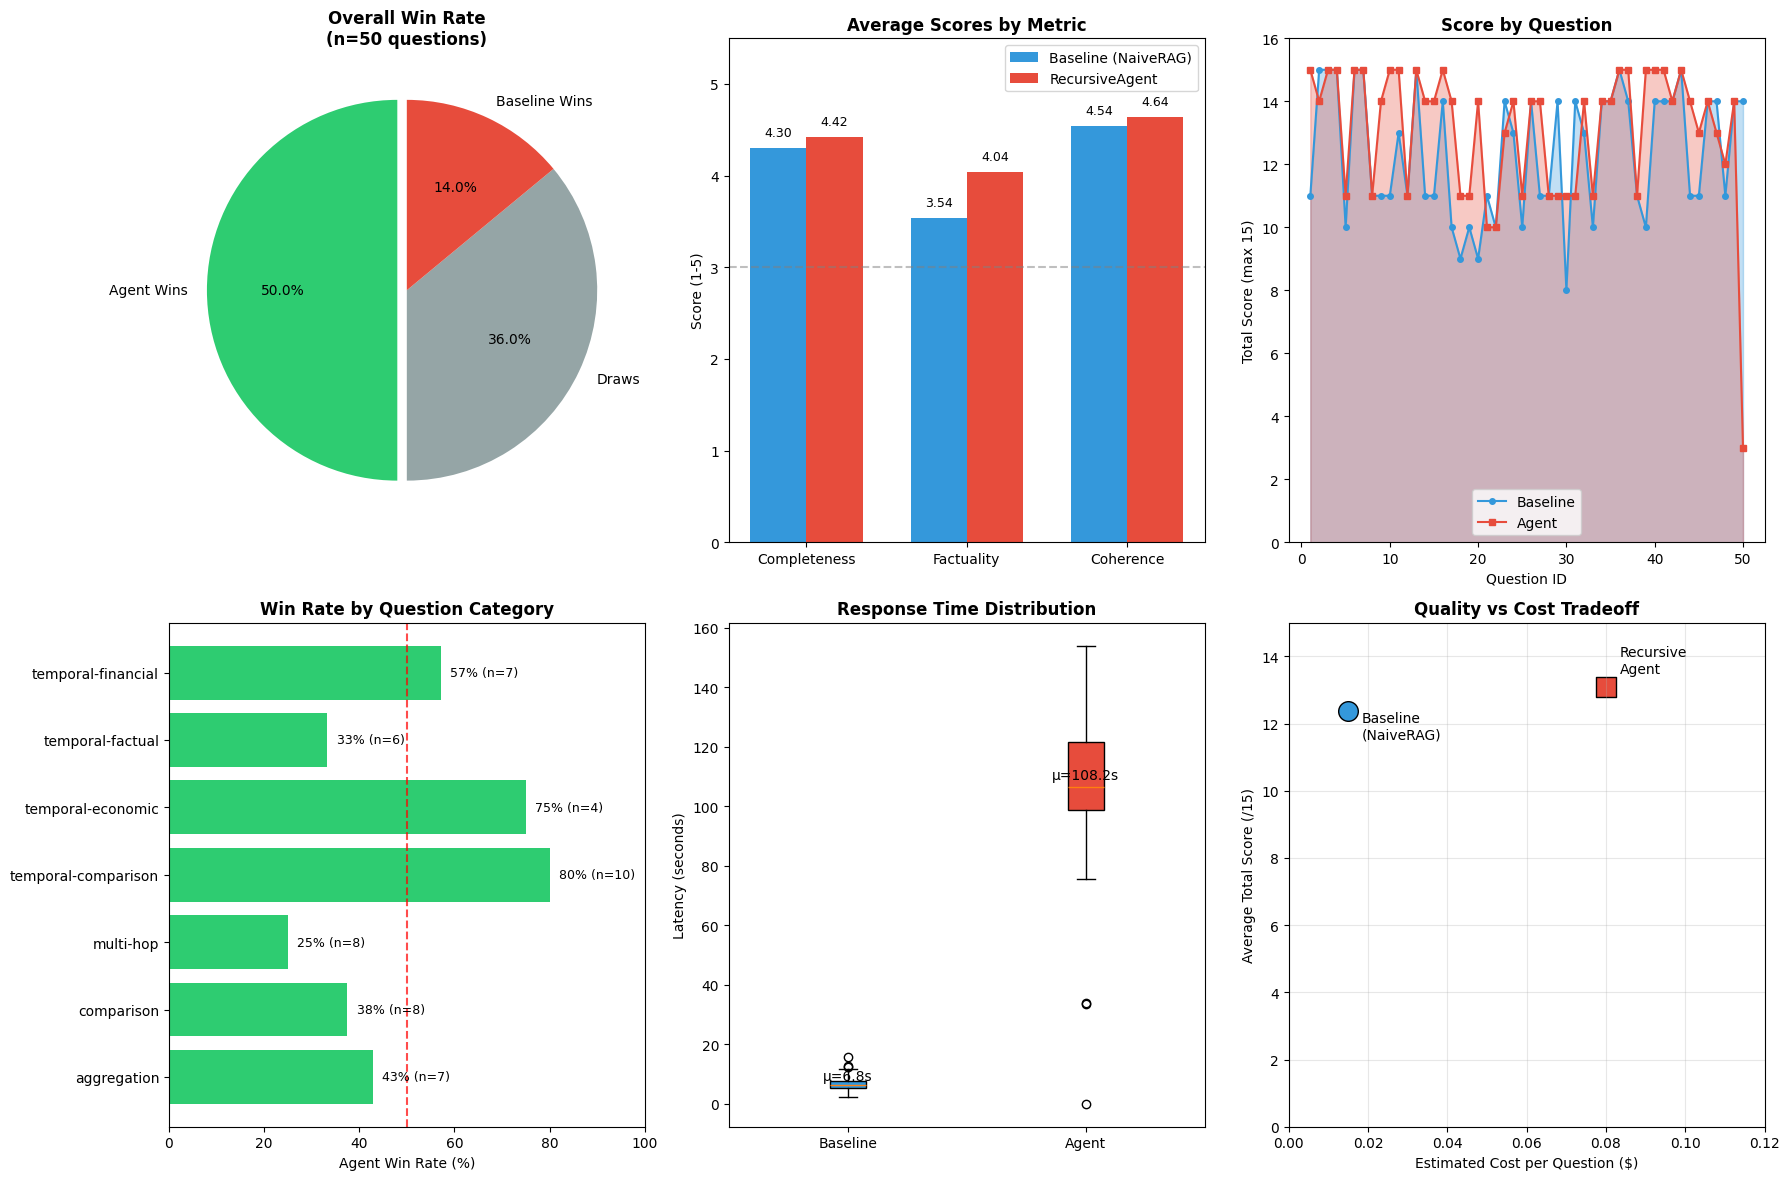


📊 Comprehensive plot saved to: /content/drive/MyDrive/Colab Notebooks/Recursive-Deep-Research/comprehensive_evaluation.png


In [15]:
#@title 7.1 Comprehensive Evaluation Plots

import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

if 'report' in dir() and report:
    fig = plt.figure(figsize=(18, 12))

    # 1. Win Rate Pie Chart
    ax1 = fig.add_subplot(2, 3, 1)
    s = report['summary']
    labels = ['Agent Wins', 'Draws', 'Baseline Wins']
    sizes = [s['agent_wins'], s['draws'], s['agent_losses']]
    colors = ['#2ecc71', '#95a5a6', '#e74c3c']
    explode = (0.05, 0, 0)
    ax1.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90, explode=explode)
    ax1.set_title(f'Overall Win Rate\n(n={s["total_questions"]} questions)', fontsize=12, fontweight='bold')

    # 2. Score Comparison Bar Chart
    ax2 = fig.add_subplot(2, 3, 2)
    metrics = ['Completeness', 'Factuality', 'Coherence']
    baseline_scores = [
        report['baseline_metrics']['avg_completeness'],
        report['baseline_metrics']['avg_factuality'],
        report['baseline_metrics']['avg_coherence']
    ]
    agent_scores = [
        report['agent_metrics']['avg_completeness'],
        report['agent_metrics']['avg_factuality'],
        report['agent_metrics']['avg_coherence']
    ]

    x = np.arange(len(metrics))
    width = 0.35

    bars1 = ax2.bar(x - width/2, baseline_scores, width, label='Baseline (NaiveRAG)', color='#3498db')
    bars2 = ax2.bar(x + width/2, agent_scores, width, label='RecursiveAgent', color='#e74c3c')

    # Add value labels on bars
    for bar, score in zip(bars1, baseline_scores):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, f'{score:.2f}', ha='center', va='bottom', fontsize=9)
    for bar, score in zip(bars2, agent_scores):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, f'{score:.2f}', ha='center', va='bottom', fontsize=9)

    ax2.set_ylabel('Score (1-5)')
    ax2.set_title('Average Scores by Metric', fontsize=12, fontweight='bold')
    ax2.set_xticks(x)
    ax2.set_xticklabels(metrics)
    ax2.legend()
    ax2.set_ylim(0, 5.5)
    ax2.axhline(y=3, color='gray', linestyle='--', alpha=0.5, label='Acceptable threshold')

    # 3. Per-Question Score Comparison
    ax3 = fig.add_subplot(2, 3, 3)
    q_ids = [r['question_id'] for r in report['detailed_results']['baseline']]
    baseline_totals = [r['completeness'] + r['factuality'] + r['coherence'] for r in report['detailed_results']['baseline']]
    agent_totals = [r['completeness'] + r['factuality'] + r['coherence'] for r in report['detailed_results']['agent']]

    ax3.fill_between(q_ids, baseline_totals, alpha=0.3, color='#3498db')
    ax3.fill_between(q_ids, agent_totals, alpha=0.3, color='#e74c3c')
    ax3.plot(q_ids, baseline_totals, 'o-', label='Baseline', color='#3498db', markersize=4)
    ax3.plot(q_ids, agent_totals, 's-', label='Agent', color='#e74c3c', markersize=4)
    ax3.set_xlabel('Question ID')
    ax3.set_ylabel('Total Score (max 15)')
    ax3.set_title('Score by Question', fontsize=12, fontweight='bold')
    ax3.legend()
    ax3.set_ylim(0, 16)

    # 4. Category-wise Win Rate
    ax4 = fig.add_subplot(2, 3, 4)
    category_wins = defaultdict(lambda: {'wins': 0, 'draws': 0, 'losses': 0, 'total': 0})

    for b, a in zip(report['detailed_results']['baseline'], report['detailed_results']['agent']):
        # Find category from GOLDEN_SET
        q_data = next((q for q in GOLDEN_SET if q['id'] == b['question_id']), None)
        if q_data:
            cat = q_data['category']
            category_wins[cat]['total'] += 1
            agent_score = a['completeness'] + a['factuality'] + a['coherence']
            base_score = b['completeness'] + b['factuality'] + b['coherence']
            if agent_score > base_score:
                category_wins[cat]['wins'] += 1
            elif agent_score == base_score:
                category_wins[cat]['draws'] += 1
            else:
                category_wins[cat]['losses'] += 1

    cats = sorted(category_wins.keys())
    win_rates = [category_wins[c]['wins'] / category_wins[c]['total'] * 100 if category_wins[c]['total'] > 0 else 0 for c in cats]

    bars = ax4.barh(cats, win_rates, color='#2ecc71')
    ax4.axvline(x=50, color='red', linestyle='--', alpha=0.7, label='50% baseline')
    ax4.set_xlabel('Agent Win Rate (%)')
    ax4.set_title('Win Rate by Question Category', fontsize=12, fontweight='bold')
    ax4.set_xlim(0, 100)

    # Add count labels
    for i, (cat, rate) in enumerate(zip(cats, win_rates)):
        ax4.text(rate + 2, i, f'{rate:.0f}% (n={category_wins[cat]["total"]})', va='center', fontsize=9)

    # 5. Latency Comparison
    ax5 = fig.add_subplot(2, 3, 5)
    baseline_latencies = [r['latency_seconds'] for r in report['detailed_results']['baseline']]
    agent_latencies = [r['latency_seconds'] for r in report['detailed_results']['agent']]

    bp = ax5.boxplot([baseline_latencies, agent_latencies], labels=['Baseline', 'Agent'], patch_artist=True)
    bp['boxes'][0].set_facecolor('#3498db')
    bp['boxes'][1].set_facecolor('#e74c3c')
    ax5.set_ylabel('Latency (seconds)')
    ax5.set_title('Response Time Distribution', fontsize=12, fontweight='bold')

    # Add mean annotations
    ax5.text(1, np.mean(baseline_latencies), f'μ={np.mean(baseline_latencies):.1f}s', ha='center', va='bottom')
    ax5.text(2, np.mean(agent_latencies), f'μ={np.mean(agent_latencies):.1f}s', ha='center', va='bottom')

    # 6. Quality vs Cost Tradeoff
    ax6 = fig.add_subplot(2, 3, 6)

    baseline_avg_score = np.mean([r['completeness'] + r['factuality'] + r['coherence'] for r in report['detailed_results']['baseline']])
    agent_avg_score = np.mean([r['completeness'] + r['factuality'] + r['coherence'] for r in report['detailed_results']['agent']])

    # Estimate costs (rough approximation)
    baseline_cost_per_q = 0.015  # ~$0.015 per question for NaiveRAG
    agent_cost_per_q = 0.08     # ~$0.08 per question for RecursiveAgent

    ax6.scatter([baseline_cost_per_q], [baseline_avg_score], s=200, c='#3498db', label='Baseline', marker='o', edgecolors='black')
    ax6.scatter([agent_cost_per_q], [agent_avg_score], s=200, c='#e74c3c', label='Agent', marker='s', edgecolors='black')

    ax6.annotate('Baseline\n(NaiveRAG)', (baseline_cost_per_q, baseline_avg_score), textcoords="offset points", xytext=(10,-20), fontsize=10)
    ax6.annotate('Recursive\nAgent', (agent_cost_per_q, agent_avg_score), textcoords="offset points", xytext=(10,10), fontsize=10)

    ax6.set_xlabel('Estimated Cost per Question ($)')
    ax6.set_ylabel('Average Total Score (/15)')
    ax6.set_title('Quality vs Cost Tradeoff', fontsize=12, fontweight='bold')
    ax6.set_xlim(0, 0.12)
    ax6.set_ylim(0, 15)
    ax6.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(os.path.join(DRIVE_PROJECT_PATH, 'comprehensive_evaluation.png'), dpi=150, bbox_inches='tight')
    plt.show()

    print(f"\n📊 Comprehensive plot saved to: {DRIVE_PROJECT_PATH}/comprehensive_evaluation.png")
else:
    print("Run the evaluation first (Section 5.2)")

In [16]:
#@title 7.2 Statistical Summary & Confidence Intervals

import scipy.stats as stats

if 'report' in dir() and report:
    print("=" * 70)
    print("STATISTICAL SUMMARY")
    print("=" * 70)

    # Extract scores
    baseline_scores = [r['completeness'] + r['factuality'] + r['coherence'] for r in report['detailed_results']['baseline']]
    agent_scores = [r['completeness'] + r['factuality'] + r['coherence'] for r in report['detailed_results']['agent']]

    n = len(baseline_scores)

    # Basic statistics
    print(f"\n📊 Sample Size: n = {n} questions")
    print(f"\n{'Metric':<25} {'Baseline':>12} {'Agent':>12} {'Δ':>10}")
    print("-" * 60)

    baseline_mean = np.mean(baseline_scores)
    agent_mean = np.mean(agent_scores)
    print(f"{'Mean Score (/15)':<25} {baseline_mean:>12.2f} {agent_mean:>12.2f} {agent_mean - baseline_mean:>+10.2f}")

    baseline_std = np.std(baseline_scores)
    agent_std = np.std(agent_scores)
    print(f"{'Std Dev':<25} {baseline_std:>12.2f} {agent_std:>12.2f}")

    # 95% Confidence Intervals
    baseline_ci = stats.t.interval(0.95, n-1, loc=baseline_mean, scale=stats.sem(baseline_scores))
    agent_ci = stats.t.interval(0.95, n-1, loc=agent_mean, scale=stats.sem(agent_scores))

    print(f"\n📈 95% Confidence Intervals:")
    print(f"   Baseline: [{baseline_ci[0]:.2f}, {baseline_ci[1]:.2f}]")
    print(f"   Agent:    [{agent_ci[0]:.2f}, {agent_ci[1]:.2f}]")

    # Paired t-test (since same questions)
    t_stat, p_value = stats.ttest_rel(agent_scores, baseline_scores)

    print(f"\n🔬 Paired t-test (Agent vs Baseline):")
    print(f"   t-statistic: {t_stat:.3f}")
    print(f"   p-value: {p_value:.4f}")
    print(f"   Significant at α=0.05: {'✅ YES' if p_value < 0.05 else '❌ NO'}")

    # Effect size (Cohen's d for paired samples)
    diff = np.array(agent_scores) - np.array(baseline_scores)
    cohens_d = np.mean(diff) / np.std(diff)

    effect_interpretation = "negligible" if abs(cohens_d) < 0.2 else \
                           "small" if abs(cohens_d) < 0.5 else \
                           "medium" if abs(cohens_d) < 0.8 else "large"

    print(f"\n📏 Effect Size (Cohen's d): {cohens_d:.3f} ({effect_interpretation})")

    # Win rate with confidence interval
    wins = sum(1 for a, b in zip(agent_scores, baseline_scores) if a > b)
    win_rate = wins / n

    # Wilson score interval for win rate
    z = 1.96  # 95% confidence
    denominator = 1 + z**2/n
    centre_adjusted_probability = win_rate + z**2 / (2*n)
    adjusted_standard_deviation = np.sqrt((win_rate*(1 - win_rate) + z**2/(4*n)) / n)

    lower = (centre_adjusted_probability - z*adjusted_standard_deviation) / denominator
    upper = (centre_adjusted_probability + z*adjusted_standard_deviation) / denominator

    print(f"\n🏆 Win Rate: {win_rate:.1%}")
    print(f"   95% CI: [{lower:.1%}, {upper:.1%}]")

    print("\n" + "=" * 70)
else:
    print("Run the evaluation first (Section 5.2)")

STATISTICAL SUMMARY

📊 Sample Size: n = 50 questions

Metric                        Baseline        Agent          Δ
------------------------------------------------------------
Mean Score (/15)                 12.38        13.10      +0.72
Std Dev                           2.02         2.20

📈 95% Confidence Intervals:
   Baseline: [11.80, 12.96]
   Agent:    [12.47, 13.73]

🔬 Paired t-test (Agent vs Baseline):
   t-statistic: 2.085
   p-value: 0.0423
   Significant at α=0.05: ✅ YES

📏 Effect Size (Cohen's d): 0.298 (small)

🏆 Win Rate: 50.0%
   95% CI: [36.6%, 63.4%]



In [17]:
#@title 7.3 Category-wise Detailed Analysis

import pandas as pd
from IPython.display import display

if 'report' in dir() and report:
    # Build category analysis
    category_data = defaultdict(lambda: {
        'baseline_scores': [], 'agent_scores': [],
        'baseline_latency': [], 'agent_latency': [],
        'wins': 0, 'losses': 0, 'draws': 0
    })

    for b, a in zip(report['detailed_results']['baseline'], report['detailed_results']['agent']):
        q_data = next((q for q in GOLDEN_SET if q['id'] == b['question_id']), None)
        if q_data:
            cat = q_data['category']
            b_score = b['completeness'] + b['factuality'] + b['coherence']
            a_score = a['completeness'] + a['factuality'] + a['coherence']

            category_data[cat]['baseline_scores'].append(b_score)
            category_data[cat]['agent_scores'].append(a_score)
            category_data[cat]['baseline_latency'].append(b['latency_seconds'])
            category_data[cat]['agent_latency'].append(a['latency_seconds'])

            if a_score > b_score:
                category_data[cat]['wins'] += 1
            elif a_score < b_score:
                category_data[cat]['losses'] += 1
            else:
                category_data[cat]['draws'] += 1

    # Create summary table
    rows = []
    for cat in sorted(category_data.keys()):
        data = category_data[cat]
        n = len(data['baseline_scores'])
        rows.append({
            'Category': cat,
            'N': n,
            'Baseline Avg': f"{np.mean(data['baseline_scores']):.2f}",
            'Agent Avg': f"{np.mean(data['agent_scores']):.2f}",
            'Δ Score': f"{np.mean(data['agent_scores']) - np.mean(data['baseline_scores']):+.2f}",
            'Win Rate': f"{data['wins']/n*100:.0f}%",
            'W/D/L': f"{data['wins']}/{data['draws']}/{data['losses']}",
            'Baseline Latency': f"{np.mean(data['baseline_latency']):.1f}s",
            'Agent Latency': f"{np.mean(data['agent_latency']):.1f}s",
        })

    df = pd.DataFrame(rows)
    print("📊 CATEGORY-WISE PERFORMANCE BREAKDOWN")
    print("=" * 100)
    display(df)

    # Identify best and worst categories
    best_cat = max(category_data.keys(), key=lambda c: np.mean(category_data[c]['agent_scores']) - np.mean(category_data[c]['baseline_scores']))
    worst_cat = min(category_data.keys(), key=lambda c: np.mean(category_data[c]['agent_scores']) - np.mean(category_data[c]['baseline_scores']))

    print(f"\n💡 KEY INSIGHTS:")
    print(f"   Best improvement: '{best_cat}' (+{np.mean(category_data[best_cat]['agent_scores']) - np.mean(category_data[best_cat]['baseline_scores']):.2f} pts)")
    print(f"   Needs work: '{worst_cat}' ({np.mean(category_data[worst_cat]['agent_scores']) - np.mean(category_data[worst_cat]['baseline_scores']):+.2f} pts)")
else:
    print("Run the evaluation first (Section 5.2)")

📊 CATEGORY-WISE PERFORMANCE BREAKDOWN


,Category,N,Baseline Avg,Agent Avg,Δ Score,Win Rate,W/D/L,Baseline Latency,Agent Latency
0,aggregation,7,12.14,12.29,+0.14,43%,3/2/2,5.5s,101.2s
1,comparison,8,13.00,12.25,-0.75,38%,3/3/2,7.8s,90.1s
2,multi-hop,8,13.38,13.88,+0.50,25%,2/5/1,6.4s,104.3s
3,temporal-comparison,10,11.60,13.80,+2.20,80%,8/2/0,5.8s,124.2s
4,temporal-economic,4,13.00,14.75,+1.75,75%,3/1/0,10.6s,125.0s
5,temporal-factual,6,13.00,13.33,+0.33,33%,2/4/0,5.4s,101.0s
6,temporal-financial,7,11.00,11.86,+0.86,57%,4/1/2,8.0s,113.8s



💡 KEY INSIGHTS:
   Best improvement: 'temporal-comparison' (+2.20 pts)
   Needs work: 'comparison' (-0.75 pts)


---
## 8. Export & Download

In [18]:
#@title 8.1 Export Results to CSV

if 'report' in dir() and report:
    # Export detailed results
    baseline_df = pd.DataFrame(report['detailed_results']['baseline'])
    agent_df = pd.DataFrame(report['detailed_results']['agent'])

    baseline_path = os.path.join(DRIVE_PROJECT_PATH, 'baseline_results.csv')
    agent_path = os.path.join(DRIVE_PROJECT_PATH, 'agent_results.csv')

    baseline_df.to_csv(baseline_path, index=False)
    agent_df.to_csv(agent_path, index=False)

    print(f"✅ Exported to Google Drive:")
    print(f"   {baseline_path}")
    print(f"   {agent_path}")
else:
    print("Run the evaluation first (Section 5.2)")

✅ Exported to Google Drive:
   /content/drive/MyDrive/Colab Notebooks/Recursive-Deep-Research/baseline_results.csv
   /content/drive/MyDrive/Colab Notebooks/Recursive-Deep-Research/agent_results.csv


In [20]:
#@title 8.2 Download Files
#@markdown Download results directly to your local machine.
import glob

from google.colab import files

DOWNLOAD_REPORT = True #@param {type:"boolean"}
DOWNLOAD_CSV = True #@param {type:"boolean"}
DOWNLOAD_PLOT = True #@param {type:"boolean"}

if DOWNLOAD_REPORT:
    report_files = sorted(glob.glob(os.path.join(DRIVE_PROJECT_PATH, 'checkpoints', 'eval_report_*.json')))
    if report_files:
        files.download(report_files[-1])

if DOWNLOAD_CSV:
    csv_path = os.path.join(DRIVE_PROJECT_PATH, 'agent_results.csv')
    if os.path.exists(csv_path):
        files.download(csv_path)

if DOWNLOAD_PLOT:
    plot_path = os.path.join(DRIVE_PROJECT_PATH, 'evaluation_plot.png')
    if os.path.exists(plot_path):
        files.download(plot_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

---

## 📝 Notes

### Cost Estimation
- **Baseline (NaiveRAG)**: ~$0.01-0.02 per question (GPT-4o-mini only)
- **RecursiveAgent**: ~$0.05-0.15 per question (Claude Sonnet + GPT-4o-mini)
- **Full 20-question evaluation**: ~$2-5 total

### Resuming After Disconnect
1. Re-run cells 1.1-1.3 (Mount Drive, Install, API Keys)
2. Re-run cells 2.1-2.4 (Define classes)
3. Re-run cell 3.1 (Dataset)
4. Re-run cell 4.1 (Config with RESUME_FROM_CHECKPOINT=True)
5. Re-run cell 5.2 (Evaluation will resume from checkpoint)

### Tips
- Start with NUM_QUESTIONS=3-5 to test the setup
- Checkpoints are saved after each question, so you won't lose progress
- All results are saved to Google Drive for persistence